<h2>Research Institute of Sweden Assignment</h2>
By Aditya Retissin Poozhiyil




<hr>

# Table of Content

<h3> Section 1 - Getting everything ready<h3>

<h3> Section 2 - Data Preparation<h3>

<h3> Section 3 - Metrics<h3>

<h3> Section 4 - Batch & Model Preparation<h3>

<h3> Section 5 - Training System A <h3>

<h3> Section 6 - Training System B <h3>

<h3> Section 6 - Observation and Limitations<h3>

# 1. Getting everything ready

* 1.1 Mounting to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

* 1.2 Installing the requirements(if you're in colab only this is needed)

In [ ]:
!pip install datasets transformers seqeval accelerate evaluate

* 1.3 Importing the necessary librarys

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer,AutoTokenizer,pipeline
from datasets import load_dataset
import evaluate
from transformers import DataCollatorForTokenClassification
import numpy as np
import os
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
from matplotlib import pyplot as plt


* 1.4 Download & loading the dataset

In [ ]:
dataset = load_dataset("Babelscape/multinerd")

* 1.5 Loading the train, validation and test split to the required variables

In [ ]:
train_dataset,validation_dataset,test_dataset = dataset["train"],dataset["validation"],dataset["test"]

* 1.6 Retrieving only the 'en' texts from the dataset using the default Huggingface 'filter' command from the dataset object.

In [ ]:
dataset_en_train = train_dataset.filter(lambda x: x["lang"]=="en")
dataset_en_val = validation_dataset.filter(lambda x: x["lang"]=="en")
dataset_en_test = test_dataset.filter(lambda x: x["lang"]=="en")

Filter:   0%|          | 0/2678400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/334800 [00:00<?, ? examples/s]

Filter:   0%|          | 0/335986 [00:00<?, ? examples/s]

# 2. Data Preparation

- We first have to tokenize our sentence. The hugging face tokenizer by default adds the special token [CLS] and the [SEP] when tokenized.

- Additionally, since adding the tokens causes misalignment with the words and the provided NER tags, we create a helper function to align the tags with the tokenized words

* 2.1 Tokenizing and aligning the NER tags after adding special([CLS] and [SEP]) tokens

In [ ]:
def tokenize_and_align_labels(row,tokenizer):

    tokenized_inputs = tokenizer(row["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(row[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100 return the original word otherwise
            if word_idx is None: #if it is a special token
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

#3. Metrics

- In order to calculate the metrics, we define the function compute_metrics() function in order to compute **precision, recall, F1 and accuracy score**. The primary metric of focus is **precision**, since we want to evaluate the model based primarily on the positive predictions made by the model. Followed by F1 score where we understand the balance of both precision and recall.

* 3.1 Loading the built-in evaluation function of the huggingface transformer

In [ ]:
seqeval = evaluate.load("seqeval") #huggingface function to calculate the precision, recall f1 and accuracy score

* 3.2 Loading the built-in evaluation function of the huggingface transformer

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

def computeOnTest(model,test_tokenizer,trainer,listOfClasses,printClassificationReport=True):
  model.eval()
  predictions,labels,score = trainer.predict(test_tokenizer) #returns predictions made on the entire dataset
  #print the score
  print("[+]Score on test set[+]")
  print("Precision : ", score["test_precision"])
  print("Accuracy : ", score["test_accuracy"])
  print("Recall : ", score["test_recall"])
  print("F1-Score : ", score["test_f1"])
  predictions = np.argmax(predictions, axis=2)

  true_predictions = [
      [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]
  true_labels = [
      [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]
  true_pred = []
  true_label = []

  #flattening the results to get entity-level results
  for j in true_predictions:
    true_pred.extend(j)
  for k in true_labels:
    true_label.extend(k)

  if printClassificationReport: #to get entity-level results
    print(classification_report(true_label,true_pred))

  return true_pred,true_label #return the true_label and true_pred to plot the confusion matrix


# 4. Batch & Model Preparation

* 4.1 Data collator function to create a DataCollator object given a tokenizer as a parameter. The object will used in training in order to prepare the batches ensuring all of them are in the same length

In [ ]:
def createCollator(tokenizer):
  return DataCollatorForTokenClassification(tokenizer=tokenizer)


* 4.2 Defining the name of the model used in both the systems followed by the
 path to save the data(checkpoint files, i.e, vocab, tokenizer, model file).

For this experiments we will be using the distilled-BERT. A model trained through knowledge distillation approach. The methodology involves a teacher-student architecture, where, the teacher corresponds to a larger and more complex model, while the latter is a smaller and less complex model.The objective of this approach is for the student model to predict the probability scores as close to the teacher model. Notably, the performance of this model is on par with BERT model, indicating the student model is able to achieve state-of-the art performance with less complexity making(110m parameters for BERT and 66m parameters for distilBERT) it computationally efficient[[1]](https://arxiv.org/pdf/1910.01108.pdf). Additionally, by using this approach we can experiment with larger batch sizes(in colab) for fast training in comparison to BERT.

In [ ]:
model_name = "distilbert-base-uncased"
model_dir = r"/content/drive/MyDrive/RISE Assignment/models" #folder path_name + /models

# 5. Training System A

- Fine-tuning an existing model on only the english version of the dataset(without any preprocessing)

* 5.1 Defining the mapping of class to index and vice-versa for System A

In [ ]:
#class_ix mapping taken from https://huggingface.co/datasets/Babelscape/multinerd?row=17
class_ix = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-BIO": 9,
    "I-BIO": 10,
    "B-CEL": 11,
    "I-CEL": 12,
    "B-DIS": 13,
    "I-DIS": 14,
    "B-EVE": 15,
    "I-EVE": 16,
    "B-FOOD": 17,
    "I-FOOD": 18,
    "B-INST": 19,
    "I-INST": 20,
    "B-MEDIA": 21,
    "I-MEDIA": 22,
    "B-MYTH": 23,
    "I-MYTH": 24,
    "B-PLANT": 25,
    "I-PLANT": 26,
    "B-TIME": 27,
    "I-TIME": 28,
    "B-VEHI": 29,
    "I-VEHI": 30,
  }
ix_class = {v:k for k,v in class_ix.items()}
label_list = [i for i in ix_class.values()] #contains all the labels

* 5.2 Defining the model for System A

In [ ]:
tokenizer_A = AutoTokenizer.from_pretrained(model_name)
model_A = AutoModelForTokenClassification.from_pretrained(
    model_name, num_labels=len(class_ix), id2label=ix_class, label2id=class_ix
)
collatorA = createCollator(tokenizer_A)


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* 5.3 Tokenize the train, val and test split

In [ ]:
tokenized_train = dataset_en_train.map(lambda x: tokenize_and_align_labels(x,tokenizer_A), batched=True)
tokenized_val = dataset_en_val.map(lambda x: tokenize_and_align_labels(x,tokenizer_A) , batched=True)
tokenized_test = dataset_en_test.map(lambda x: tokenize_and_align_labels(x,tokenizer_A) , batched=True)

Map:   0%|          | 0/262560 [00:00<?, ? examples/s]

Map:   0%|          | 0/32820 [00:00<?, ? examples/s]

Map:   0%|          | 0/32908 [00:00<?, ? examples/s]

* 5.4 Training the model for system A


In [ ]:
training_args = TrainingArguments(
    output_dir=os.path.join(model_dir,"system_A"),
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # push_to_hub=True,
)

trainer = Trainer(
    model=model_A,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer_A,
    data_collator=collatorA,
    compute_metrics=compute_metrics,
)

trainer.train()
#if want to run on checkpoint. Only point to the folder, comment trainer.train() and uncomment the code below
# trainer.train("/content/drive/MyDrive/RISE Assignment/models/system_A/checkpoint-16412")
#Compute the testing score
classes = list(class_ix.keys())
t_l,t_p  = computeOnTest(model_A,tokenized_test,trainer,listOfClasses=classes) #prints the metrics overall, and entity-level metrics and returns the true label and the predicted label


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
5,0.007300,0.070838,0.889396,0.906302,0.897769,0.983425


[+]Score on test set[+]
Precision :  0.9077679149681893
Accuracy :  0.9869144874288596
Recall :  0.9291479820627803
F1-Score :  0.9183335260338382
              precision    recall  f1-score   support

      B-ANIM       0.73      0.77      0.75      3208
       B-BIO       0.33      0.12      0.18        16
       B-CEL       0.76      0.78      0.77        82
       B-DIS       0.78      0.78      0.78      1518
       B-EVE       0.94      0.95      0.94       704
      B-FOOD       0.63      0.66      0.65      1132
      B-INST       0.41      0.58      0.48        24
       B-LOC       0.98      0.98      0.98     24048
     B-MEDIA       0.94      0.96      0.95       916
      B-MYTH       0.85      0.69      0.76        64
       B-ORG       0.97      0.97      0.97      6618
       B-PER       0.99      1.00      0.99     10530
     B-PLANT       0.64      0.76      0.69      1788
      B-TIME       0.83      0.82      0.82       578
      B-VEHI       0.87      0.81      0.8

* 5.5 Normalizing and plotting the confusion matrix

In [ ]:
cf = confusion_matrix(t_l,t_p,labels=classes)
normed_c = (cf.T / cf.astype(np.float).sum(axis=1)).T #normalizing the confusion matrix

<ipython-input-20-8df237182159>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normed_c = (cf.T / cf.astype(np.float).sum(axis=1)).T #normalizing the confusion matrix
<ipython-input-20-8df237182159>:2: RuntimeWarning: invalid value encountered in divide
  normed_c = (cf.T / cf.astype(np.float).sum(axis=1)).T #normalizing the confusion matrix


[Text(0.5, 80.7222222222222, 'Predicted Label'),
 Text(158.22222222222223, 0.5, 'True Label')]

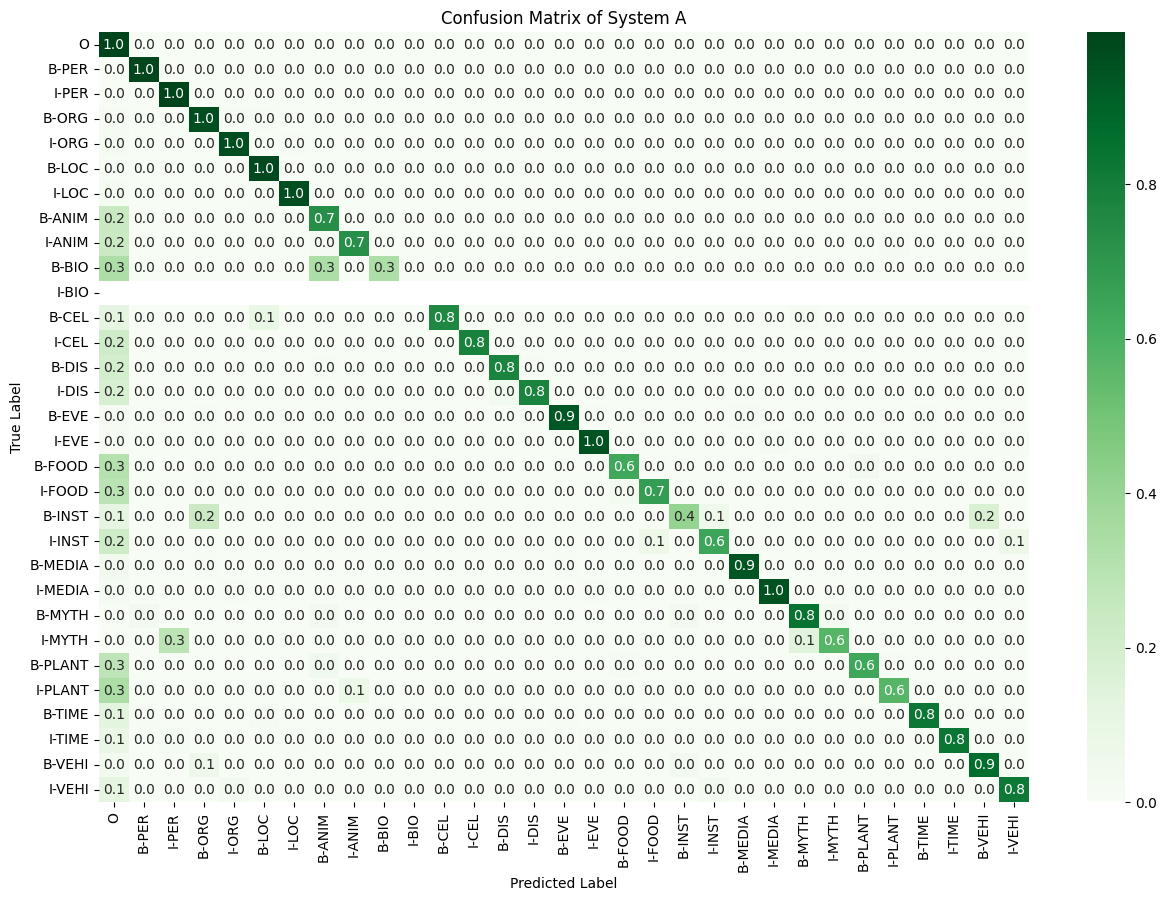

In [ ]:
plt.figure(figsize=(15,10))
plt.title("Confusion Matrix of System A")
fig_confusion = sns.heatmap(normed_c,annot=True,fmt=".1f",cmap="Greens",xticklabels=classes, yticklabels=classes)
fig_confusion.set(xlabel="Predicted Label",ylabel="True Label")

# 6. Training System B

* Fine-tuning after preprocessing the english dataset by removing certain tags.


* 6.1 Preprocessing the dataset for training System B

- Helper function to replace the tags to 0 if the tags is not PERSON(PER), ORGANIZATION(ORG), LOCATION(LOC), DISEASES(DIS), ANIMAL(ANIM)

In [ ]:
def check(ner_tag):
  inclusive_tags = [1,2,3,4,5,6,7,8,13,14]

  """
    To check whether the tags falls within : PERSON(PER), ORGANIZATION(ORG), LOCATION(LOC), DISEASES(DIS), ANIMAL(ANIM)
  """
  if ner_tag in inclusive_tags:
    return True
  else:
    return False


def replace_tag(row):
  """
    Function to check and replace the tags by the corresponding condition
  """
  #row contains -> "tokens", "ner_tags", "lang"
  ner_tags = []
  remap = {13:9,14:10} #to remap specific integers(13 to 9 and 14 to 10) to have them in order to avoid index out of bounds when using the cross entropy loss
  for i in row["ner_tags"]:
    tags_temp = []
    for tag in i:
      if check(tag):
        if tag in remap: #check if the tag is 13 or 14, and remap them to 9 and 10 respectively.
          tags_temp.append(remap[tag])
        else:
          tags_temp.append(tag)
      else:
        tags_temp.append(0)

    ner_tags.append(tags_temp)

  row["ner_tags"] = ner_tags
  return row

* 6.2 Defining the class to index mapping and vice versa

In [ ]:
class_ix = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-DIS": 9,
    "I-DIS": 10,
  }

ix_class = {v:k for k,v in class_ix.items()}
label_list = [i for i in ix_class.values()] #contains all the labels

* 6.3 Preprocessing the train, val and test split by replacing the tags

In [ ]:
#Using the map function to do the required preprocessing on batches of rows
dataset_en_preprocessed_train = dataset_en_train.map(lambda x: replace_tag(x),batched=True)
dataset_en_preprocessed_val = dataset_en_val.map(lambda x: replace_tag(x),batched=True)
dataset_en_preprocessed_test = dataset_en_test.map(lambda x: replace_tag(x),batched=True)

Map:   0%|          | 0/262560 [00:00<?, ? examples/s]

Map:   0%|          | 0/32820 [00:00<?, ? examples/s]

Map:   0%|          | 0/32908 [00:00<?, ? examples/s]

* 6.4 Instantiating the model for system B

In [ ]:
tokenizer_B = AutoTokenizer.from_pretrained(model_name)
model_B = AutoModelForTokenClassification.from_pretrained(
    model_name, num_labels=len(class_ix), id2label=ix_class, label2id=class_ix
)
collatorB = createCollator(tokenizer_B)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* 6.5 Tokenizing and aligning the tags for all the splits

In [ ]:
tokenized_train = dataset_en_preprocessed_train.map(lambda x: tokenize_and_align_labels(x,tokenizer_B), batched=True)
tokenized_val = dataset_en_preprocessed_val.map(lambda x: tokenize_and_align_labels(x,tokenizer_B), batched=True)
tokenized_test = dataset_en_preprocessed_val.map(lambda x: tokenize_and_align_labels(x,tokenizer_B), batched=True)

Map:   0%|          | 0/262560 [00:00<?, ? examples/s]

Map:   0%|          | 0/32820 [00:00<?, ? examples/s]

* 6.6 Training system B

In [ ]:
training_args = TrainingArguments(
    output_dir=os.path.join(model_dir,"system_B"),
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # push_to_hub=True,
)

trainer = Trainer(
    model=model_B,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer_B,
    data_collator=collatorB,
    compute_metrics=compute_metrics,
)

trainer.train()
#if want to run on checkpoint. Only point to the folder, comment trainer.train() and uncomment the code below
# trainer.train("/content/drive/MyDrive/RISE Assignment/models/system_B/checkpoint-16412")

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.018900,0.025663,0.932626,0.936816,0.934716,0.991380
2,0.010800,0.028063,0.938695,0.938202,0.938449,0.991546
3,0.005700,0.032704,0.935493,0.945419,0.940430,0.991760
4,0.003500,0.038058,0.936357,0.944367,0.940345,0.991858
5,0.002100,0.040977,0.938631,0.944463,0.941538,0.991953


TrainOutput(global_step=20515, training_loss=0.012140325150154521, metrics={'train_runtime': 8501.9964, 'train_samples_per_second': 154.411, 'train_steps_per_second': 2.413, 'total_flos': 2.4407185701733056e+16, 'train_loss': 0.012140325150154521, 'epoch': 5.0})

In [ ]:
classes = list(class_ix.keys())
t_l , t_p  = computeOnTest(model_B,tokenized_test,trainer,listOfClasses=classes) #prints the metrics overall, and entity-level metrics

[+]Score on test set[+]
Precision :  0.9326259694532997
Accuracy :  0.9913801974085185
Recall :  0.9368159441762653
F1-Score :  0.9347162613257034
              precision    recall  f1-score   support

      B-ANIM       0.74      0.70      0.72      2268
       B-DIS       0.78      0.72      0.75      3390
       B-LOC       0.98      0.98      0.98     15700
       B-ORG       0.96      0.96      0.96      5474
       B-PER       0.99      1.00      1.00     15014
      I-ANIM       0.77      0.66      0.71      1154
       I-DIS       0.76      0.71      0.74      2502
       I-LOC       0.96      0.96      0.96      7234
       I-ORG       0.96      0.97      0.97      7824
       I-PER       1.00      1.00      1.00     15984
           O       1.00      1.00      1.00    681478

    accuracy                           0.99    758022
   macro avg       0.90      0.88      0.89    758022
weighted avg       0.99      0.99      0.99    758022



* 6.7 Plotting the confusion matrix for system B

In [ ]:
cf = confusion_matrix(t_l,t_p,labels=classes)
normed_c = (cf.T / cf.astype(np.float).sum(axis=1)).T

[Text(0.5, 80.7222222222222, 'Predicted Label'),
 Text(95.72222222222221, 0.5, 'True Label')]

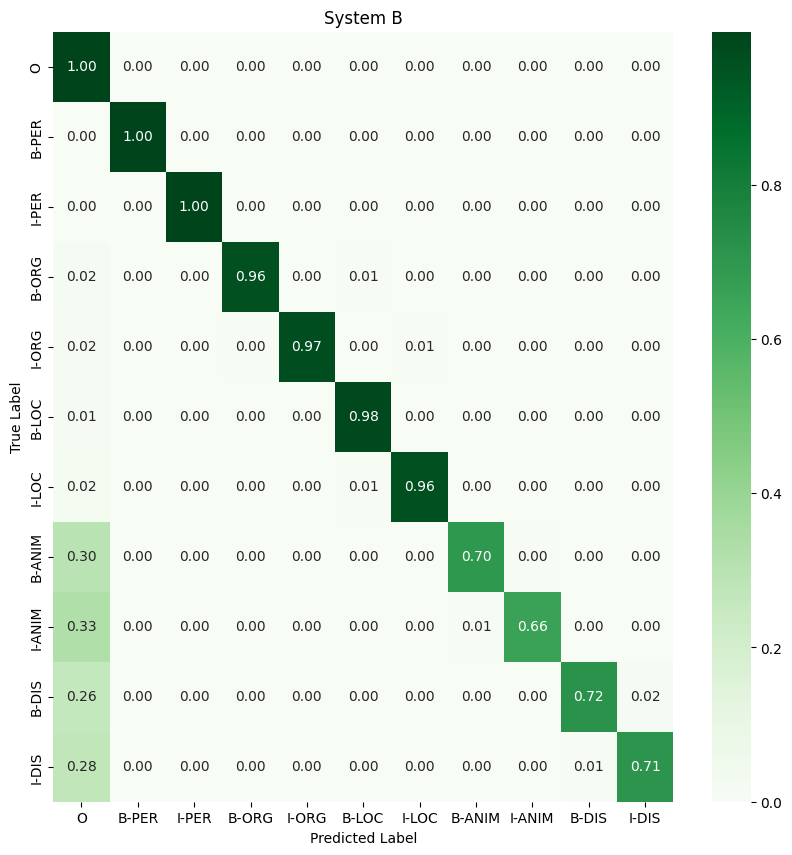

In [ ]:
# ax= plt.subplot()
plt.figure(figsize=(10,10))
plt.title("System B")
fig_confusion = sns.heatmap(normed_c,annot=True,fmt=".2f",cmap="Greens",xticklabels=classes, yticklabels=classes)
fig_confusion.set(xlabel="Predicted Label",ylabel="True Label")
# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

#Observations

The findings indicate that System B performs better than System A, where the overall precision for A is 90% and B is 93%. The F1-score also shows
the same pattern where system A reported a score of 91% and the latter recieves the score of 93%, indicating that the model performed
better when dropping the number of classes from 31 to 11, giving the model fewer classes to learn from, hence improving the overall performance of the model. Looking at the entity-level performance, the performance of both the systems achieves greater than 80 % for most entites across all metrics. When analyzing the confusion matrix of both the system, we can see that most of
the classes have undergone misclassification where system A has predicted O for all the instances. A similar result was seen when analyzing
system B where entities such as ANIM and DIS has been misclassified as O. We observe that these classes were also misclassified in System A, but increased misclassification have been observed in System B. This makes sense because O is a general tag, and by replacing with many of the tags as O, it might be that the words present in the misclassified classes is closely related to the O tag. Aditionally, since we are replacing a significant portion of tags with O, thereby increasing the distribution of the O(602884 to 681478) causing it to be misclassified.


#Limitations

- One main limitation in this approach is the choice of model. Since we are using a "small" model, exploring larger and more complex models such as roBERTa, LLaMA or other LLM's would be interesting to try.

- For some entities, class imbalance was observed. Sampling techniques or using a larger language model to label these entities may help in improving the performance

- Since we are using uncased version of distilBERT, meaning that it is case insensitive, maybe using a cased version may improve the performance for our case. However, we speculate that this may report in a similar performance as majority of the classes have achieved high performance.

